# CS166 - Final Project - Roomba
### *Or Segal*
***

For this project, I will be simulating the behavior of Roomba - a robotic vacuum cleaner that moves around the house with the objective of cleaning the entire place at a minimal time/energy. The challenges that Roomba strategies face apart from the requirement to minimize the time spent cleaning are wide - covering different rooms in the house, exploring unfamiliar territories, avoiding obstacles and so on. In this simulation, I will aim to generate different environments for the Roomba (i.e., houses at different sizes, number of rooms, and room configurations) and test several strategies which it can employ. The strategies will be compared based on two measurements - number of steps as a proxy of energy and percent of the house being clean as a measure of efficiency.

The environment in which the simulation will take place is a house with a variable number of rooms. The house will be a two-dimensional plane at a length and width of our choosing, broken down to $1\times1$ cells. The number of internal walls can be specified and the configuration of each of them (horizontal versus vertical) is determined randomly at an equal probability. Doors will be placed between every room at random positions with a uniform probability. The fact that we have multiple parameters for the configuration of the house allows us to simulate a very large set of possible houses that the Roomba might encounter in the real world, which would make the simulation more applicable. The existence of doors, for example, would be critical for properly accounting for the difference between a random strategy and one that is actively looking for a door.

The model for the house as an environment was built with several assumptions behind it. First, I only considered here house structures with empty rooms with no furniture or obstacles other than the walls that separate the rooms. This assumption is meant to focus the attention of the simulation on the behavior of the Roomba strategies in houses with multiple rooms and can be easily adjusted by adding obstacles in different sizes at random positions in the rooms. Another assumption relates to the proportions between the object sizes. To make things simple, I will consider the robot as having a size of 1 cell, which in practice means that it is at the size of the wall's width. This is a reasonable assumption as these two sizes are in the same order of magnitude in the real world. In case we would want to make these proportions even more realistic, we could calibrate the resolution (e.g., set the robot to have a size of $2 \times 2$ cells). A third assumption relates to the configuration of the house which is only composed of rectangular rooms at equal sizes. This assumption is made for ease of coding as I aimed for building houses based on set parameters. This should not affect the behavior of the Roomba too much, as the strategies tested do not count on the room being rectangular and should behave similarly in rooms with other shapes.


## Building the Simulation
The simulation is composed of two classes - `House` and `Roomba`. 

The `House` class is the one that holds the parameters that determine the configuration of the house - dimensions, number of walls, wall width, and the initial location of the Roomba (where its home base is located in the house). The methods of the class build the initial layout of the floor and then adds the walls to it. The number of walls is first randomly split between the horizontal and vertical configuration and then evenly positioned based on that split.

The `Roomba` class is the one that holds all the parameters of the robot (the house it is in, the current position and more) as well as the methods for its movement based on the determined strategies. We will be testing three strategies, each incorporating a different level of randomness. 

First, we will build the `zig_zag_strategy` which is the fastest one for a full sweep of a room according to Gylling & Elmarsson (2018). In this strategy, we move the robot to the north west corner of the house and sweep the first room in zig-zags (all the way to the right, one down, all the way to the left, one down and so on). We then find the door to the room to the east and continue to go through each room in another larger zig-zag between the rooms (through the room all the way to the right, one room down and so on). This strategy is completely deterministic. The second strategy is the `fully_random_strategy` which will be a random walk throughout the house. The robot will keep walking while choosing the directions at random for a limited amount of time ($W \times L \times 10$, where $W$ is the house width and $L$ is the house length) or the cleaned area is above a certain threshold (defined as 95%). The final strategy, `random_switch_rooms_strategy`, is similar to the fully random one, but with a probability of switching rooms. Once every several steps (default probability for switching is 0.001, about once every 1000 steps) the robot is choosing a direction, finds the door to the next room in that direction, moves there, and continues the random walk there. 

In [38]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
import time
import operator

plt.style.use('ggplot')

In [18]:
class House():
    '''
    Randomly generates a house plan based on the following parameters:
    
    ### Attributes ###
    house_dimensions: (int, int)
        dimensions of the house (how big is the total matrix). default: (60, 100)
    n_walls: int
        number of walls in the house. default: 2
    percent_furniture: float
        how much of the floor is covered with furnitures. default: 0.1    
    
    '''
    def __init__(self, house_dimensions=(60, 100), n_walls=2, wall_width=1): 
        self.house_dimensions = house_dimensions
        self.floor_plan = np.zeros(self.house_dimensions)
        self.n_walls = n_walls
        self.n_rooms = 1
        self.wall_width = wall_width
        self.roomba_base = (1, 1)
        
        # add external walls
        self.floor_plan[:1] = -1
        self.floor_plan[-1:] = -1
        self.floor_plan[:,:1] = -1
        self.floor_plan[:,-1:] = -1
    
    def add_walls(self, door_length=3):
        '''
        Make sure the number of walls is smaller than the maximal allowed 
        so that we ensure than all rooms have a dimension higher than 8 
        (the small dimension / 10; because wall width is 2). If n_walls 
        greater than max allowed, take the max allowed. Walls will be 
        spread evenly for simplicity.
        For each wall, randomly sample whether it is vertical or 
        horizontal (50%). Sample the location of the wall. If there are 
        other walls in this configuration, make sure at least a distance 
        of 8 between one another. Add doors, randomly positioned between 
        each section, at length 3.
        '''
        self.horizontal_walls = []
        self.vertical_walls = []
        
        # calculate max number of walls allowed, set n_walls to min(max_walls, n_walls)
        self.n_walls = min(min(self.house_dimensions) // 10 - 1, self.n_walls)
        
        # determine how many horizontal and vertical walls
        for _ in range(self.n_walls):
            if np.random.random() < 0.5:
                self.horizontal_walls.append(0)
            else:
                self.vertical_walls.append(0)
        
        # build the walls
        if self.horizontal_walls:
            dist_between_walls = self.house_dimensions[0] // \
                                 (len(self.horizontal_walls) + 1)
            for i in range(len(self.horizontal_walls)):
                self.horizontal_walls[i] = (i+1) * dist_between_walls
                self.floor_plan[self.horizontal_walls[i]:
                                self.horizontal_walls[i]+self.wall_width] = -1
        
        if self.vertical_walls:
            dist_between_walls = self.house_dimensions[1] // \
                                 (len(self.vertical_walls) + 1)
            for i in range(len(self.vertical_walls)):
                self.vertical_walls[i] = (i+1) * dist_between_walls
                self.floor_plan[:,self.vertical_walls[i]:
                                self.vertical_walls[i]+self.wall_width] = -1
        
        # build the doors, each at length door_length
        if self.horizontal_walls:
            sections = [2] + self.vertical_walls + [self.house_dimensions[1]]
            for i in range(len(self.horizontal_walls)):
                for j in range(len(self.vertical_walls) + 1):
                    door_position = np.random.randint(sections[j]+2, 
                                                      sections[j+1]-2-door_length)
                    self.floor_plan[self.horizontal_walls[i]:
                                    self.horizontal_walls[i]+self.wall_width,
                                    door_position:door_position+door_length] = 0
        if self.vertical_walls:
            sections = [2] + self.horizontal_walls + [self.house_dimensions[0]]
            for i in range(len(self.vertical_walls)):
                for j in range(len(self.horizontal_walls) + 1):
                    door_position = np.random.randint(sections[j]+2, 
                                                      sections[j+1]-2-door_length)
                    self.floor_plan[door_position:door_position+door_length, 
                                    self.vertical_walls[i]:
                                    self.vertical_walls[i]+self.wall_width] = 0
        
        # calculate the number of rooms
        self.n_rooms = (len(self.horizontal_walls) + 1) * \
                       (len(self.vertical_walls) + 1)
    
    def draw_house(self):
        plt.figure(figsize=(10,5))
        plt.imshow(self.floor_plan, cmap="inferno")
        plt.show()
    
    def show_example_house(self):
        print("Example house:")
        print("    Dimentions: {}".format(self.house_dimensions))
        print("    Number of walls: {}".format(self.n_walls))
        print("    Number of rooms: {}".format(self.n_rooms))
        self.draw_house()


Example house:
    Dimentions: (30, 50)
    Number of walls: 2
    Number of rooms: 3


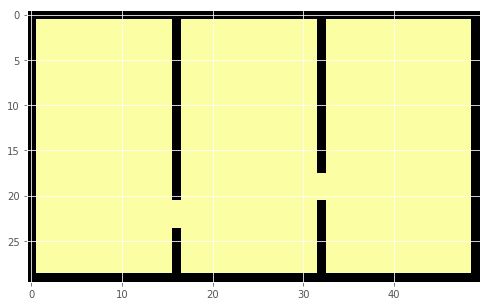

---------------------------------------------------------------
Example house:
    Dimentions: (80, 100)
    Number of walls: 7
    Number of rooms: 20


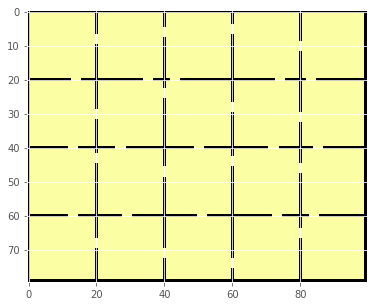

In [25]:
house = House(house_dimensions=(30, 50), n_walls=3)
house.add_walls()
house.show_example_house()

print("---------------------------------------------------------------")

house = House(house_dimensions=(80, 100), n_walls=7)
house.add_walls()
house.show_example_house()

In [35]:
class Roomba():
    '''
    Simulating the roomba vacuum cleaning robot.
    
    ### Attributes ###
    strategy_number: int
        one of the two strategies. default: 1
    house: Class
        an object of House class for the house that the robot 
        will clean in.
    
    '''
    
    def __init__(self, house, strategy_number=1):
        self.strategy_number = strategy_number
        self.n_moves = 0
        self.floor_dimensions = house.house_dimensions
        self.visited_map = house.floor_plan.copy()
        self.current_position = house.roomba_base
        self.moves_history = []
        self.allowed_directions = ["n", "s", "e", "w"]
        
        self.opposite_direction = {"n": "s", 
                                   "s": "n",
                                   "e": "w",
                                   "w": "e"}
        self.direction_90 =       {"n": "e", 
                                   "s": "w",
                                   "e": "s",
                                   "w": "n"}
        self.direction_270 =      {"n": "w", 
                                   "s": "e",
                                   "e": "n",
                                   "w": "s"}
    
    def draw_visited_map(self):
        """
        Make a nice drawing of the floor map with the marking of the cleaned areas.
        """
        plt.figure(figsize=(10,5))
        plt.imshow(self.visited_map, cmap="inferno")
        plt.show()
        
    def move(self, direction):
        """
        Moves the robot to the direction dictated: n, s, e, w.
        """
        if direction == "n":
            new_position = (self.current_position[0]-1, self.current_position[1])
        elif direction == "s":
            new_position = (self.current_position[0]+1, self.current_position[1])
        elif direction == "e":
            new_position = (self.current_position[0], self.current_position[1]+1)
        elif direction == "w":
            new_position = (self.current_position[0], self.current_position[1]-1)
        else:
            raise ValueError('The direction indicated is not valid. \
                             Should be n, s, e, or w.')
        
        if self.visited_map[new_position] == -1:
            return False
        else:
            self.visited_map[self.current_position] += 1
            self.moves_history.append(self.current_position)
            self.current_position = new_position
            self.n_moves += 1
            return True
    
    def move_n_times(self, direction, n_moves=1):
        """
        Move n_moves times.
        """
        all_moves = []
        for i in range(n_moves):
            all_moves.append(self.move(direction))
        return all(all_moves)
    
    def distance_sensor(self, direction, sight_radius=2, distance=1):
        """
        Returns the array that is in the field of view towards the direction ahead,
        at a radius of sight_radius.
        """
        if direction == "n":
            return self.visited_map[max(self.current_position[0]-distance, 0),
                                    max(self.current_position[1]-sight_radius, 0):
                                    min(self.current_position[1]+sight_radius+1, 
                                        len(self.visited_map[0]))]
        elif direction == "s":
            return self.visited_map[min(self.current_position[0]+distance, 
                                        len(self.visited_map[1])-1),
                                    max(self.current_position[1]-sight_radius, 0):
                                    min(self.current_position[1]+sight_radius+1, 
                                        len(self.visited_map[0]))]
        elif direction == "e":
            return self.visited_map[max(self.current_position[0]-sight_radius, 0):
                                    min(self.current_position[0]+sight_radius+1, 
                                        len(self.visited_map)),
                                    min(self.current_position[1]+distance, 
                                        len(self.visited_map[0])-1)]
        elif direction == "w":
            return self.visited_map[max(self.current_position[0]-sight_radius, 0):
                                    min(self.current_position[0]+sight_radius+1, 
                                        len(self.visited_map)),
                                    max(self.current_position[1]-distance, 0)]
    
    def how_much_wall_in_sight(self, direction, sight_radius=2):
        """
        When looking ahead with radius sight_radius, how much of the cells
        are walls.
        """
        return sum(self.distance_sensor(direction) == -1)
    
    def is_approaching_wall(self, direction):
        """
        Checks if reaching a wall, even if in front of a door (which otherwise will
        seem like an open direction).
        """
        if self.how_much_wall_in_sight(direction) > 1:
            return True
        else:
            return False

    
    def move_until_blocked(self, direction):
        """
        Move the robot in the same direction until it reaches a block.
        """
        next_position_allowed = True
        while next_position_allowed:
            next_position_allowed = self.move(direction)
    
    def move_until_wall(self, direction):
        """
        Move the robot in the same direction until it reaches a wall.
        The difference between this method and the move_until_blocked one is 
        that in this one, the robot will stop when reaching a door (which is
        not a block, but we don't want to cross it).
        """
        while True:
            if not self.is_approaching_wall(direction):
                self.move(direction)
            else:
                break
            
    
    def find_the_door(self, direction):
        """
        Finds the position of the door in the wall in the direction ahead.
        Assumes that the robot is right next to the wall.
        First go all the way in 90 degrees to the direction, and then all
        the way in 270 degrees, until seeing the door.
        If changing direction for the second time, assume that there is no 
        door and return False.
        """
        direction_in_line_with_wall = self.direction_90[direction]
        n_switches = 0
        while True:
            if self.how_much_wall_in_sight(direction) == 2:
                self.move(direction_in_line_with_wall)
                return True
            if not self.move(direction_in_line_with_wall):
                direction_in_line_with_wall = self.opposite_direction[direction_in_line_with_wall]
                n_switches += 1
                if n_switches == 2:
                    return False
            
    def find_nw_corner(self):
        """
        Move to the north west corner.
        """
        self.move_until_wall("n")
        self.move_until_wall("w")
    
    def find_nw_room(self):
        """
        Move to the north west room.
        """
        while True:
            if not self.find_the_door("n"):
                break
        while True:
            if not self.find_the_door("w"):
                break
    
    def zig_zag_room(self):
        """
        Assumes that the robot is in the nw corner of the room, and 
        uses the zig-zag strategy to cover the room.
        Assumes a clean room (no furniture).
        """
        currect_direction = "e"
        allowed_down = True
        while allowed_down:
            self.move_until_wall(currect_direction)
            allowed_down = not self.is_approaching_wall("s")
            if allowed_down:
                self.move("s")
            currect_direction = self.opposite_direction[currect_direction]
            
    def go_to_next_room(self, direction):
        """
        Go to the next room in the described direction.
        If there is a next room, enter the room (move two cells), and return
        True. Else, return False.
        """
        self.move_until_wall(direction)
        if self.find_the_door(direction):
            self.move_n_times(direction, n_moves=2)
            return True
        else:
            return False
        
        
    def zig_zag_strategy(self):
        """
        Perform the zigzag strategy.
        First find the north west room, then go between the rooms in zig_zag.
        """
        self.find_nw_room()
        self.find_nw_corner()
        direction = "e"
        allowed_down = True
        while allowed_down:
            allowed_horizontal = True
            while allowed_horizontal:
                self.zig_zag_room()
                if self.go_to_next_room(direction):
                    self.find_nw_corner()
                else:
                    allowed_horizontal = False
                    direction = self.opposite_direction[direction]
            if self.go_to_next_room("s"):
                self.find_nw_corner()
            else:
                allowed_down = False
            
    def percent_cleaned(self):
        return np.sum(self.visited_map != 0) / self.visited_map.size
    
    def is_house_clean(self, desired_clean=0.95):
        """
        Check if the robot cleaned a section of the house that is greater
        than p_clean. default=95%
        """
        return self.percent_cleaned() > desired_clean
    
    def fully_random_strategy(self, k=10):
        """
        The fully (silly) random strategy - go wild for nxmxk steps (n and m are the 
        floor dimensions, k is a the multiplication factor) or until you 
        reached level of cleaning (default = 95%) and then stop.
        """
        n_allowed_moves = self.floor_dimensions[0] * self.floor_dimensions[1] * k
        while (self.n_moves < n_allowed_moves) and (not self.is_house_clean()):
            # randomly choose a direction
            direction = np.random.choice(self.allowed_directions)
            self.move(direction)
     
    def is_between_door(self):
        """
        Checks if the robot is right in the opening of the door (caused a 
        bug in the random + switch rooms strategy).
        """
        if self.distance_sensor("n", sight_radius=0, distance=3) == -1 and \
           self.distance_sensor("s", sight_radius=0, distance=3) == -1:
                return True
        elif self.distance_sensor("e", sight_radius=0, distance=3) == -1 and \
             self.distance_sensor("w", sight_radius=0, distance=3) == -1:
                return True
        else:
            return False
    
    def random_switch_rooms_strategy(self, k=10, p_switch=0.001):
        """
        The random switch rooms strategy - similar to the fully random one, but switch
        rooms with a probability p_switch. go until you reached level of cleaning 
        (default = 95%) and then stop.
        """
        n_allowed_moves = self.floor_dimensions[0] * self.floor_dimensions[1] * k
        switch_counter = 0
        while (self.n_moves < n_allowed_moves) and (not self.is_house_clean()):
            # randomly choose a direction
            direction = np.random.choice(self.allowed_directions)
            
            if np.random.random() < p_switch and not self.is_between_door():
                # switch room
                self.go_to_next_room(direction)
                switch_counter += 1
            else:
                self.move(direction)
        

Basic house plan:


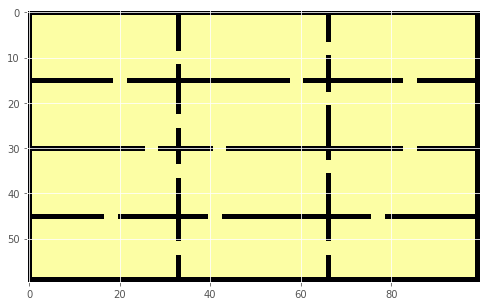

Zig-zag strategy:
Number of steps: 6130   Percent cleaned: 0.993


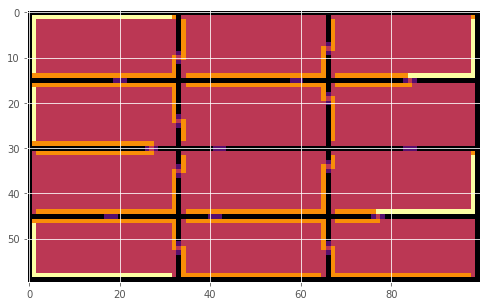

Fully random strategy:
Number of steps: 60000   Percent cleaned: 0.726


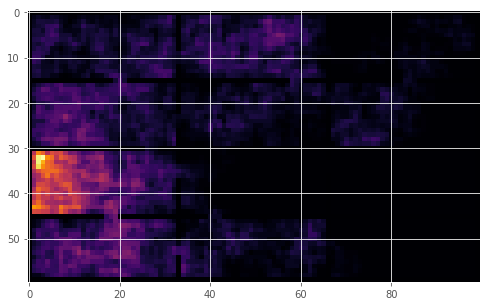

Random + switching rooms strategy (switching prob: 0.005):
Number of steps: 60000   Percent cleaned: 0.928


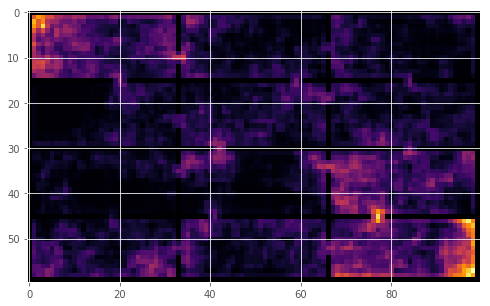

Random + switching rooms strategy (switching prob: 0.01):
Number of steps: 56574   Percent cleaned: 0.950


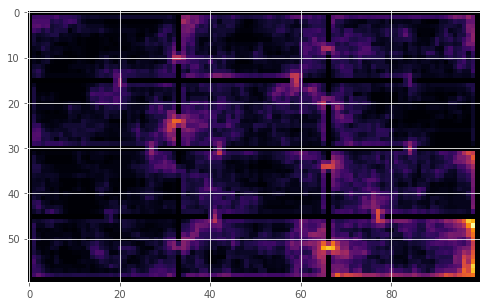

In [130]:
house = House(house_dimensions=(60, 100), n_walls=10)
house.add_walls()

roomba = Roomba(house)
print("Basic house plan:")
roomba.draw_visited_map()

print("Zig-zag strategy:")
roomba.zig_zag_strategy()
print("Number of steps: {}   Percent cleaned: {:.3f}".format(roomba.n_moves, roomba.percent_cleaned()))
roomba.draw_visited_map()

roomba = Roomba(house)
print("Fully random strategy:")
roomba.fully_random_strategy()
print("Number of steps: {}   Percent cleaned: {:.3f}".format(roomba.n_moves, roomba.percent_cleaned()))
roomba.draw_visited_map()

roomba = Roomba(house)
print("Random + switching rooms strategy (switching prob: 0.005):")
roomba.random_switch_rooms_strategy(p_switch=0.005)
print("Number of steps: {}   Percent cleaned: {:.3f}".format(roomba.n_moves, roomba.percent_cleaned()))
roomba.draw_visited_map()

roomba = Roomba(house)
print("Random + switching rooms strategy (switching prob: 0.01):")
roomba.random_switch_rooms_strategy(p_switch=0.01)
print("Number of steps: {}   Percent cleaned: {:.3f}".format(roomba.n_moves, roomba.percent_cleaned()))
roomba.draw_visited_map()


We can see above three examples for house plans at different sizes. For the third one, we can also see heat maps of the moves taken in each of the strategies. We can see that the zig-zag strategy is by far the most efficient one, and that the random strategy with room switching can be more efficient than purely random strategies if the percent of switching is high enough.

## Experiments
We will compare the different strategies and measure the two parameters we described before - the number of steps (in the case of the random strategy it will be capped) and the percentage of the cleaned floor.

For the changing house sizes, we will start with (30, 30) and work our way up to (100, 100) in increments of 10, all with two walls (could be either 3 or 4 rooms). For each house size, we will record our two measurements. For the changing room numbers, we will set all the houses to a constant size (100, 100) and vary the number of walls from 1 to 7 (2-16 rooms).

In [61]:
%%time
# Strategy performance in for different house sizes

house_sizes_performance1 = {}
house_sizes_performance2 = {}
house_sizes_performance3 = {}
house_sizes_performance4 = {}

range_start = 30
range_end = 101
n_trials = 10

counter = 1
start_time = time.time()
last_trial_time = time.time()

for i in range(range_start, range_end, 10):
    for j in range(i, range_end, 10):
        print("\rTrial {trial_number} - testing size {house_size}. Time of last trial: {last_time:.2f} sec. Average time per trial: {ave_time:.2f} sec"
          .format(trial_number=counter, house_size=(i, j),
                  last_time=time.time()-last_trial_time,
                  ave_time=(time.time()-start_time)/counter), end="")
        last_trial_time = time.time()
        
        # check if the size was already encountered
        if i*j not in house_sizes_performance1:
            house_sizes_performance1[i*j] = {"n_moves":[],
                                            "percent_clean":[]}
            house_sizes_performance2[i*j] = {"n_moves":[],
                                            "percent_clean":[]}            
            house_sizes_performance3[i*j] = {"n_moves":[],
                                            "percent_clean":[]}
            house_sizes_performance4[i*j] = {"n_moves":[],
                                            "percent_clean":[]}
        
        
        for _ in range(n_trials):
            house = House(house_dimensions=(i, j), n_walls=2)
            house.add_walls()

            roomba = Roomba(house)
            roomba.zig_zag_strategy()
            house_sizes_performance1[i*j]["n_moves"].append(roomba.n_moves)
            house_sizes_performance1[i*j]["percent_clean"].append(roomba.percent_cleaned())

            roomba = Roomba(house)
            roomba.fully_random_strategy()
            house_sizes_performance2[i*j]["n_moves"].append(roomba.n_moves)
            house_sizes_performance2[i*j]["percent_clean"].append(roomba.percent_cleaned())

            roomba = Roomba(house)
            roomba.random_switch_rooms_strategy(p_switch=0.005)
            house_sizes_performance3[i*j]["n_moves"].append(roomba.n_moves)
            house_sizes_performance3[i*j]["percent_clean"].append(roomba.percent_cleaned())

            roomba = Roomba(house)
            roomba.random_switch_rooms_strategy(p_switch=0.01)
            house_sizes_performance4[i*j]["n_moves"].append(roomba.n_moves)
            house_sizes_performance4[i*j]["percent_clean"].append(roomba.percent_cleaned())

        counter += 1

print("\n")

Trial 36 - testing size (100, 100). Time of last trial: 66.12 sec. Average time per trial: 25.73 sec

CPU times: user 16min 22s, sys: 5.54 s, total: 16min 27s
Wall time: 16min 42s


In [146]:
house_sizes_performance_list = {}
strategy_data = [house_sizes_performance1, house_sizes_performance2, house_sizes_performance3, house_sizes_performance4]

for strategy in range(len(strategy_data)):
    house_sizes_performance_list[strategy] = {"house_sizes":[],
                                               "moves_per_size":[],
                                               "moves_per_size_CI2":[],
                                               "moves_per_size_CI97":[],                                              
                                               "cleaned_per_size":[],
                                               "cleaned_per_size_CI2":[],
                                               "cleaned_per_size_CI97":[]}

    sorted_x = sorted(strategy_data[strategy].items(), key=operator.itemgetter(0))
    for i in range(len(sorted_x)):
        house_sizes_performance_list[strategy]["house_sizes"].append(sorted_x[i][0])
        house_sizes_performance_list[strategy]["moves_per_size"].append(np.mean(sorted_x[i][1]["n_moves"]))
        house_sizes_performance_list[strategy]["moves_per_size_CI2"].append(np.percentile(sorted_x[i][1]["n_moves"], 2.5))
        house_sizes_performance_list[strategy]["moves_per_size_CI97"].append(np.percentile(sorted_x[i][1]["n_moves"], 97.5))
        house_sizes_performance_list[strategy]["cleaned_per_size"].append(np.mean(sorted_x[i][1]["percent_clean"]))
        house_sizes_performance_list[strategy]["cleaned_per_size_CI2"].append(np.percentile(sorted_x[i][1]["percent_clean"], 2.5))
        house_sizes_performance_list[strategy]["cleaned_per_size_CI97"].append(np.percentile(sorted_x[i][1]["percent_clean"], 97.5))        

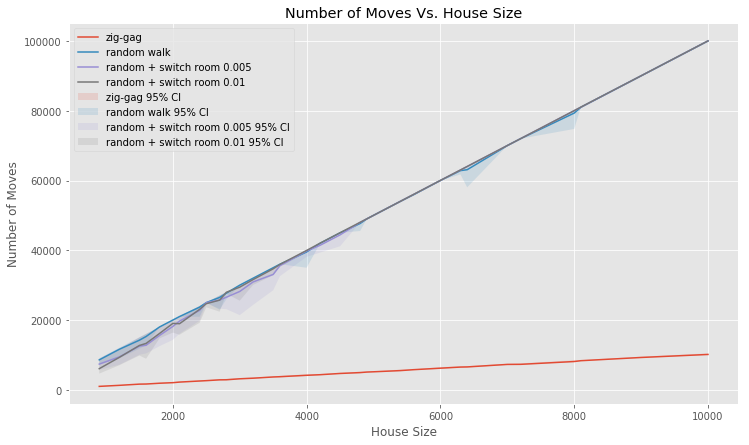

In [147]:
plt.figure(figsize=(12,7))

strategy_name = ["zig-gag", "random walk", "random + switch room 0.005", "random + switch room 0.01"]

for strategy in range(4):
    plt.plot(house_sizes_performance_list[strategy]["house_sizes"], 
             house_sizes_performance_list[strategy]["moves_per_size"], label=strategy_name[strategy])
    plt.fill_between(house_sizes_performance_list[strategy]["house_sizes"], 
                     house_sizes_performance_list[strategy]["moves_per_size_CI2"], 
                     house_sizes_performance_list[strategy]["moves_per_size_CI97"], 
                     alpha = 0.15, label = strategy_name[strategy]+' 95% CI')

# np.array(house_sizes_performance_list1["moves_per_size"][:8])
# np.array([[1,2,3], [4, 5,6]])
plt.title("Number of Moves Vs. House Size")
plt.xlabel("House Size")
plt.ylabel("Number of Moves")
plt.legend()
plt.show()

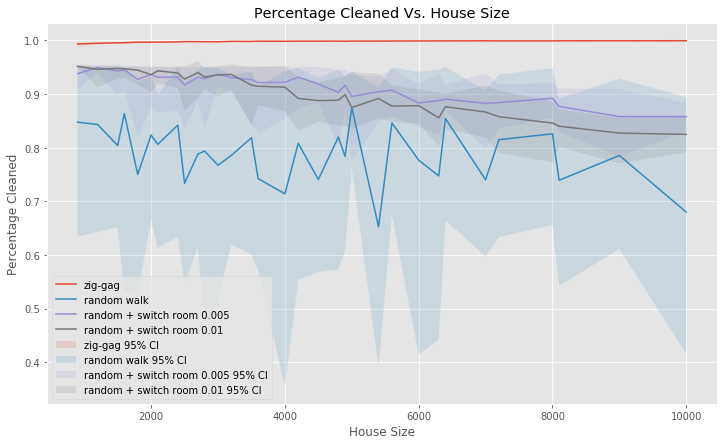

In [148]:
plt.figure(figsize=(12,7))

strategy_name = ["zig-gag", "random walk", "random + switch room 0.005", "random + switch room 0.01"]

for strategy in range(4):
    plt.plot(house_sizes_performance_list[strategy]["house_sizes"], 
             house_sizes_performance_list[strategy]["cleaned_per_size"], label=strategy_name[strategy])
    plt.fill_between(house_sizes_performance_list[strategy]["house_sizes"], 
                     house_sizes_performance_list[strategy]["cleaned_per_size_CI2"], 
                     house_sizes_performance_list[strategy]["cleaned_per_size_CI97"], 
                     alpha = 0.15, label = strategy_name[strategy]+' 95% CI')

# np.array(house_sizes_performance_list1["moves_per_size"][:8])
# np.array([[1,2,3], [4, 5,6]])
plt.title("Percentage Cleaned Vs. House Size")
plt.xlabel("House Size")
plt.ylabel("Percentage Cleaned")
plt.legend()
plt.show()

In [123]:
%%time
# Strategy performance in for different numbers of rooms
rooms_performance1 = {}
rooms_performance2 = {}
rooms_performance3 = {}
rooms_performance4 = {}

range_start = 1
range_end = 7
n_trials = 10

counter = 1
start_time = time.time()
last_trial_time = time.time()

for i in range(range_start, range_end):
    print("\rTrial {trial_number} - number of walls: {n_walls}. Time of last trial: {last_time:.2f} sec. Average time per trial: {ave_time:.2f} sec"
      .format(trial_number=counter, n_walls=i,
              last_time=time.time()-last_trial_time,
              ave_time=(time.time()-start_time)/counter), end="")
    last_trial_time = time.time()

    for _ in range(n_trials):
        house = House(house_dimensions=(100, 100), n_walls=i)
        house.add_walls()
        
        # check if the number of rooms was already encountered
        if house.n_rooms not in rooms_performance1:
            rooms_performance1[house.n_rooms] = {"n_moves":[],
                                       "percent_clean":[]}
            rooms_performance2[house.n_rooms] = {"n_moves":[],
                                       "percent_clean":[]}            
            rooms_performance3[house.n_rooms] = {"n_moves":[],
                                       "percent_clean":[]}
            rooms_performance4[house.n_rooms] = {"n_moves":[],
                                       "percent_clean":[]}

        roomba = Roomba(house)
        roomba.zig_zag_strategy()
        rooms_performance1[house.n_rooms]["n_moves"].append(roomba.n_moves)
        rooms_performance1[house.n_rooms]["percent_clean"].append(roomba.percent_cleaned())

        roomba = Roomba(house)
        roomba.fully_random_strategy()
        rooms_performance2[house.n_rooms]["n_moves"].append(roomba.n_moves)
        rooms_performance2[house.n_rooms]["percent_clean"].append(roomba.percent_cleaned())

        roomba = Roomba(house)
        roomba.random_switch_rooms_strategy(p_switch=0.005)
        rooms_performance3[house.n_rooms]["n_moves"].append(roomba.n_moves)
        rooms_performance3[house.n_rooms]["percent_clean"].append(roomba.percent_cleaned())

        roomba = Roomba(house)
        roomba.random_switch_rooms_strategy(p_switch=0.01)
        rooms_performance4[house.n_rooms]["n_moves"].append(roomba.n_moves)
        rooms_performance4[house.n_rooms]["percent_clean"].append(roomba.percent_cleaned())

    counter += 1

print("\n")

Trial 6 - number of walls: 6. Time of last trial: 90.80 sec. Average time per trial: 70.34 sec

CPU times: user 8min 12s, sys: 3.95 s, total: 8min 16s
Wall time: 8min 28s


In [142]:
room_performance_list = {}
strategy_data = [rooms_performance1, rooms_performance2, rooms_performance3, rooms_performance4]

for strategy in range(len(strategy_data)):
    room_performance_list[strategy] = {"number_of_rooms":[],
                                               "moves_per_size":[],
                                               "moves_per_size_CI2":[],
                                               "moves_per_size_CI97":[],                                              
                                               "cleaned_per_size":[],
                                               "cleaned_per_size_CI2":[],
                                               "cleaned_per_size_CI97":[]}

    sorted_x = sorted(strategy_data[strategy].items(), key=operator.itemgetter(0))
    for i in range(len(sorted_x)):
        room_performance_list[strategy]["number_of_rooms"].append(sorted_x[i][0])
        room_performance_list[strategy]["moves_per_size"].append(np.mean(sorted_x[i][1]["n_moves"]))
        room_performance_list[strategy]["moves_per_size_CI2"].append(np.percentile(sorted_x[i][1]["n_moves"], 2.5))
        room_performance_list[strategy]["moves_per_size_CI97"].append(np.percentile(sorted_x[i][1]["n_moves"], 97.5))
        room_performance_list[strategy]["cleaned_per_size"].append(np.mean(sorted_x[i][1]["percent_clean"]))
        room_performance_list[strategy]["cleaned_per_size_CI2"].append(np.percentile(sorted_x[i][1]["percent_clean"], 2.5))
        room_performance_list[strategy]["cleaned_per_size_CI97"].append(np.percentile(sorted_x[i][1]["percent_clean"], 97.5))        

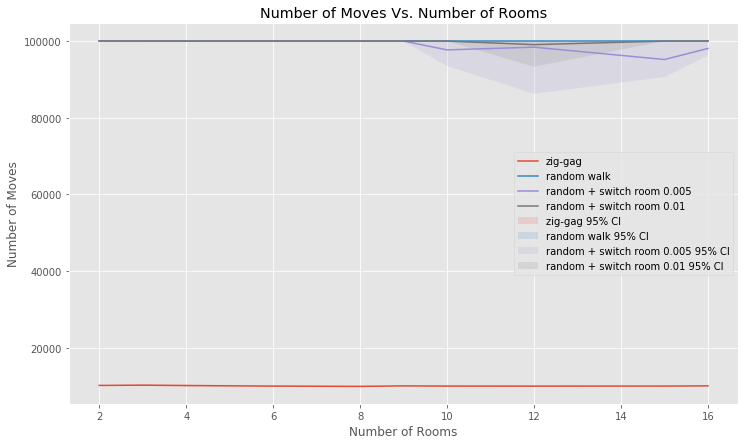

In [149]:
plt.figure(figsize=(12,7))

strategy_name = ["zig-gag", "random walk", "random + switch room 0.005", "random + switch room 0.01"]

for strategy in range(4):
    plt.plot(room_performance_list[strategy]["number_of_rooms"], 
             room_performance_list[strategy]["moves_per_size"], label=strategy_name[strategy])
    plt.fill_between(room_performance_list[strategy]["number_of_rooms"], 
                     room_performance_list[strategy]["moves_per_size_CI2"], 
                     room_performance_list[strategy]["moves_per_size_CI97"], 
                     alpha = 0.15, label = strategy_name[strategy]+' 95% CI')

# np.array(house_sizes_performance_list1["moves_per_size"][:8])
# np.array([[1,2,3], [4, 5,6]])
plt.title("Number of Moves Vs. Number of Rooms")
plt.xlabel("Number of Rooms")
plt.ylabel("Number of Moves")
plt.legend()
plt.show()

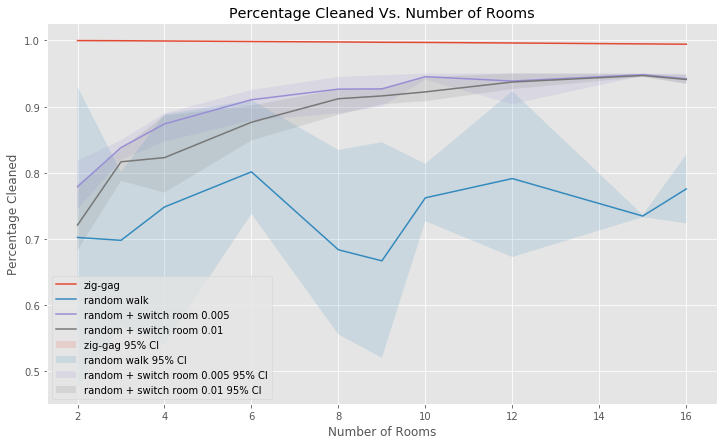

In [144]:
plt.figure(figsize=(12,7))

strategy_name = ["zig-gag", "random walk", "random + switch room 0.005", "random + switch room 0.01"]

for strategy in range(4):
    plt.plot(room_performance_list[strategy]["number_of_rooms"], 
             room_performance_list[strategy]["cleaned_per_size"], label=strategy_name[strategy])
    plt.fill_between(room_performance_list[strategy]["number_of_rooms"], 
                     room_performance_list[strategy]["cleaned_per_size_CI2"], 
                     room_performance_list[strategy]["cleaned_per_size_CI97"], 
                     alpha = 0.15, label = strategy_name[strategy]+' 95% CI')

# np.array(house_sizes_performance_list1["moves_per_size"][:8])
# np.array([[1,2,3], [4, 5,6]])
plt.title("Percentage Cleaned Vs. Number of Rooms")
plt.xlabel("Number of Rooms")
plt.ylabel("Percentage Cleaned")
plt.legend()
plt.show()

A word on the uncertainty - I ran the simulation for ten times and provided the 95% confidence intervals to all the measurements. We can see that different strategies have different levels of uncertainty. As expected, the zig-zag strategy, which is deterministic as itself, is only influenced in the changing environment and hence have a very narrow confidence interval. The random strategies have a wider confidence interval, where the fully random strategy has the largest uncertainty. 


## Conclusions
We compared here three strategies (one of them with two parameters) over two metrics - the number of moves taken by the robot and the percentage of the cleaned surface. The results in the case of the zig-zag strategy are not surprising as this strategy is close to being optimal - ~100% cleaned at close to minimal number of steps. We can also see a linear relationship (close to 1:1) between the number of moves and the size of the house. The results in the cases of the randomized strategies are the more interesting ones. 

First, as expected, we can see that in these strategies too, the number of moves is linearly related to the size of the house due to the cap of moves that we put on the random strategies (size of the house times 10). In the case of the random+room switch strategy we see a slight divergence from that relationship in the case of small house sizes and a large number of rooms, which indicate that this strategy is slightly energetically favorable. With the percentage of cleaned surface, however, the differences are greater when comparing the two random strategies. The random+room switch strategy is outperforming the fully random one across all measurements, which indicate that the addition of the room switching function is leading to higher efficiency. 

Since the random strategies are a type of random walk in a limited space, it is guaranteed that the robot will finish cleaning the entire house in a finite time. However, as expected, the performance of these strategies cannot be compared to the performance of the close-to-optimal zig-zag strategy. It is important to note that the major advantage of random strategies are not in the case of well-known structures. For that matter, even changing the number of rooms and their size is maintaining the same structure. Instead, the added value is for dealing with unknown obstacles that cannot be predicted such as furniture in the middle of the room. Such unexpected obstacles can interrupt the expected performance of the zig-zag strategy as it could get confused with unexpected structures such as finding a corner of an L shaped couch when looking for a corner of a room (similarly to being stuck in a local optimum). In that case, the best way to go would be to combine the strategies - follow a close-to-optimal strategy such as the zig-zag one, and add random behavior at a certain probability. This probability can be affected by the current state (how far into the cleaning are we?) and the environment (are the more obstacles than usual here?).


## References
* Gylling & Elmarsson (2018) - Improving robotic vacuum cleaners - https://www.diva-portal.org/smash/get/diva2:1213349/FULLTEXT02.pdf